 ## Topic Extraction
 The following pipeline will be used to extract topics from the reviews:
 - import the data (pandas)
 - clean the data
   - correct spelling (autocorrect)
   - remove punctuation (nltk.tokenize.RegexpTokenizer)
   - remove stop words (nltk.corpus.stopwords)
   - remove numbers (re.sub(r'\d+', '', text))
   - lemmatize (nltk.stem.WordNetLemmatizer)
 - audition topic extraction methods
   - spacy with bertopic
   - gensim LDAModel
   - sklearn LDA, NMF, LSA, etc.
 - visualize topics per topic extraction method
 - consider grouping topics per star rating
 - etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from autocorrect import Speller
import spacy
from bertopic import BERTopic
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

# from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# import string
import re

# set the plot style
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [2]:
# read in the stop words
# stop words taken from https://gist.github.com/deekayen/4148741
with open("data/stop_words.txt", "r") as f:
    stop_words = [x.replace("\n", "") for x in f.readlines()[1:]]

In [3]:
# "adjectives_text" column
def get_adjectives(text):
    blob = TextBlob(text)
    return [word for (word, tag) in blob.tags if tag == "JJ"]


def prepare_text(text):
    auto_spell = Speller(lang="en")
    # correct spelling
    autocorrected_text = auto_spell(text)
    # remove punctuation
    removed_punc_text = re.sub(r"[^\w\s]", "", autocorrected_text)
    # remove stop words
    word_tokens = word_tokenize(removed_punc_text)
    no_stop_words_text = " ".join(
        [w for w in word_tokens if not w.lower() in stop_words]
    )
    # remove numbers
    no_numbers_text = re.sub(r"\d+", "", no_stop_words_text)
    # lemmatize
    lemmatized_text = " ".join(
        [WordNetLemmatizer().lemmatize(x) for x in no_numbers_text.split(" ")]
    )
    # return the cleaned text (in lowercase)
    return lemmatized_text.lower()

In [4]:
# "autocorrect_text" column
auto_spell = Speller(lang="en")

In [5]:
df = (
    pd.read_json(path_or_buf="data/train_reviews.json").assign(
        **{
            # reassigning the stars column to be an integer
            "stars": lambda x: x["stars"].str.extract("(\d+)").astype(int),
            # creating a "prepped" version of the text column by removing stopwords
            # and converting to lowercase
            "stopwords_removed_text": lambda x: x["text"]
            .str.lower()
            .str.replace(
                # pat="$|".join([x for x in stopwords if len(x) > 2]),
                pat="$|".join(stop_words),
                repl="",
                regex=True,
            ),
            # creating a "autocorrected" version of the text column
            # the autocorrect takes around 2 mins to apply to each row
            # "autocorrect_text": lambda x: x["text"].apply(lambda x: auto_spell(x)),
            # creating a "prepped" version of the text column by applying the
            # prepare_text function to each row (this step takes about 4 mins)
            "prepped_text": lambda x: x["text"].apply(lambda x: prepare_text(x)),
            # creating a "adjectives_text" column pulling out all the
            # adjectives from the "prepped_text" column to quickly see what adjectives
            # are used to get an idea of tone
            "adjectives_text": lambda d: d.apply(
                lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1
            ),
        }
    )
    # when looking at the data initially, I noticed that there are some reviews
    # that are complete duplicates across the title and text columns. I decided to drop these
    # to avoid any over representation of these reviews
    .drop_duplicates(subset=["title", "text"])
    # following the row dropping reset the index to be sequential
    .reset_index(drop=True)
)
df.head()

,date,title,text,url,stars,stopwords_removed_text,prepped_text,adjectives_text
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,1,used national rail twice and on both occasions...,used national twice occasion i staff unpleasan...,"national, twice, i, unpleasant, unfriendly, in..."
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,1,i phoned national rail to find out why several...,i phone national train cancelled brighton none...,"national, english, southampton, central, centr..."
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,1,i travel from brokenhast to southampton centra...,i brokenhast southampton central without ticke...,"southampton, central, i, awful, i, sarcastic, ..."
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,4,saved about £50 on a single trip using nationa...,saved using nationalrail specific train inexp...,"specific, easy"
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,4,i always use the national rail enquiry site wh...,i national enquiry site planning journey site ...,"i, national"


 ### Topic Extraction with Spacy and BERTopic

In [6]:
# create a function which will return a flattened list given a list of lists
def flatten(l):
    return [item for sublist in l for item in sublist]


def spacy_bertopic_pipeline(list_of_texts, plot=True):
    # load the spacy model
    # python -m spacy download en_core_web_md
    nlp = spacy.load("en_core_web_md")
    # define the bertopic model with the spacy model as the embedding model
    topic_model = BERTopic(
        embedding_model=nlp,
        language="english",
        calculate_probabilities=True,
        top_n_words=10,
        nr_topics=10,
    )
    _, _ = topic_model.fit_transform(list_of_texts)
    if plot:
        fig = topic_model.visualize_topics()
        fig.show()

    return pd.DataFrame(
        [topic_model.get_topic(topic) for topic in topic_model.get_topics().keys()]
    ).T

In [7]:
topics_df = spacy_bertopic_pipeline(df["adjectives_text"].tolist(), plot=True)

In [8]:
plot_df = (
    topics_df.melt(var_name="topic_id")
    .assign(
        **{
            "topic_id": lambda x: x["topic_id"].astype(str),
            "word": lambda x: x["value"].str[0],
            "weight": lambda x: x["value"].str[1].astype(float),
        }
    )
    .replace("", np.nan)
    .dropna()
    .drop(columns=["value"])
)

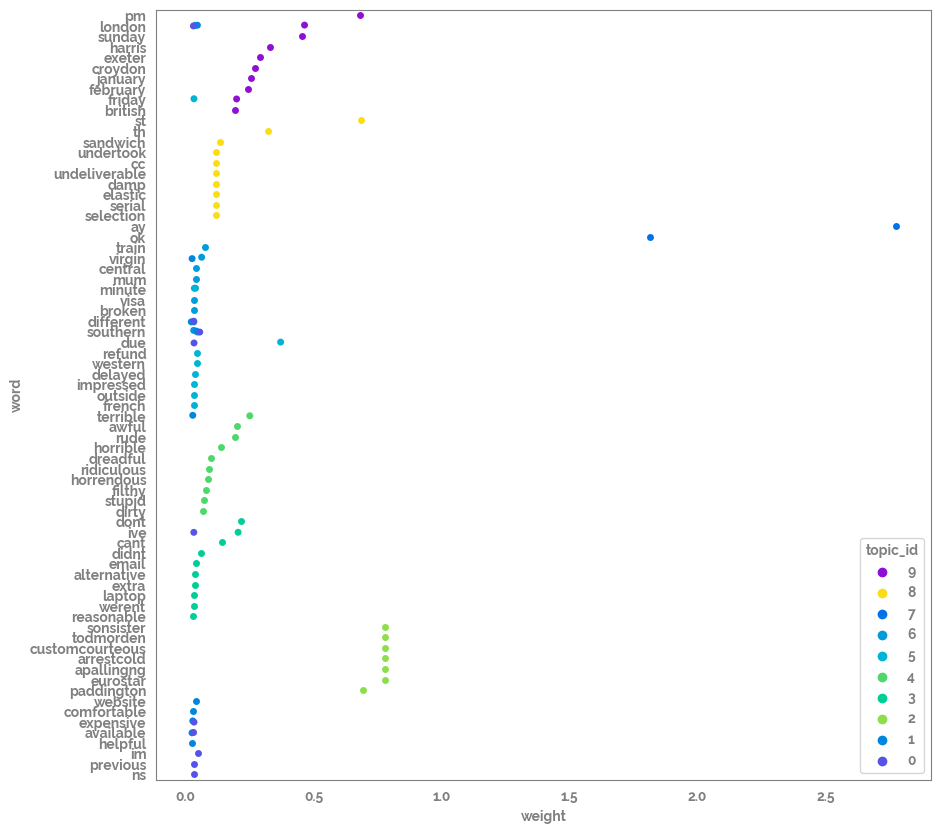

In [9]:
_ = plt.figure(figsize=(10, 10))
_ = sns.stripplot(
    data=plot_df.sort_values(by=["topic_id", "weight"], ascending=False),
    x="weight",
    y="word",
    hue="topic_id",
)

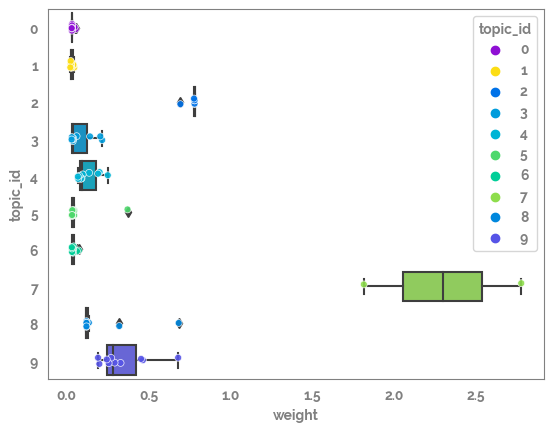

In [10]:
_ = sns.boxplot(data=plot_df, x="weight", y="topic_id")
_ = sns.stripplot(
    data=plot_df,
    x="weight",
    y="topic_id",
    hue="topic_id",
    edgecolor="white",
    linewidth=0.5,
    alpha=0.9,
)

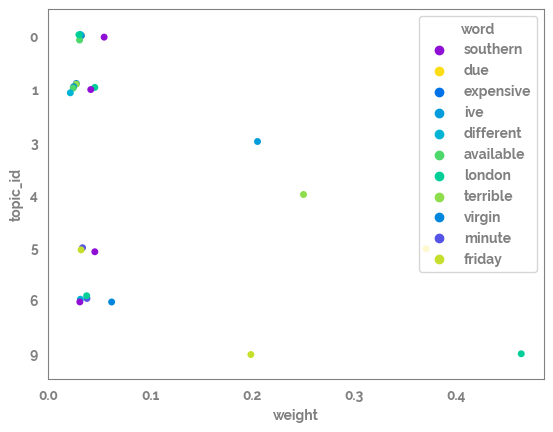

In [11]:
multi_topic_words = plot_df["word"].value_counts().loc[lambda x: x > 1].index.tolist()
_ = sns.stripplot(
    data=plot_df.loc[lambda x: x["word"].isin(multi_topic_words)],
    x="weight",
    hue="word",
    y="topic_id",
)

 ### Topic Extraction with LDA (gensim)

In [12]:
def lda_pipeline(list_of_texts, plot=True):
    # create a dictionary of words and their respective integer ids
    dictionary = Dictionary(list_of_texts)
    # create a corpus object which contains the integer ids of the words
    # along with the number of times they appear in each document
    corpus = [dictionary.doc2bow(text) for text in list_of_texts]
    # create the LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=10,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha="auto",
        per_word_topics=True,
    )

    return (
        pd.DataFrame(
            lda_model.print_topics(), columns=["topic_id", "topic_words_weights"]
        )["topic_words_weights"]
        .str.split("+", expand=True)
        .T.melt(var_name="topic_id")
        .assign(
            **{
                "topic_id": lambda x: x["topic_id"].astype(str),
                "weight": lambda x: x["value"]
                .str.split("*", expand=True)[0]
                .astype(float),
                "word": lambda x: x["value"]
                .str.split("*", expand=True)[1]
                .str.replace('"', ""),
            }
        )
        .drop(columns=["value"])
    )

In [13]:
topics_df = lda_pipeline(
    list_of_texts=df["adjectives_text"].apply(lambda x: x.split(", ")).tolist(),
    plot=True,
)

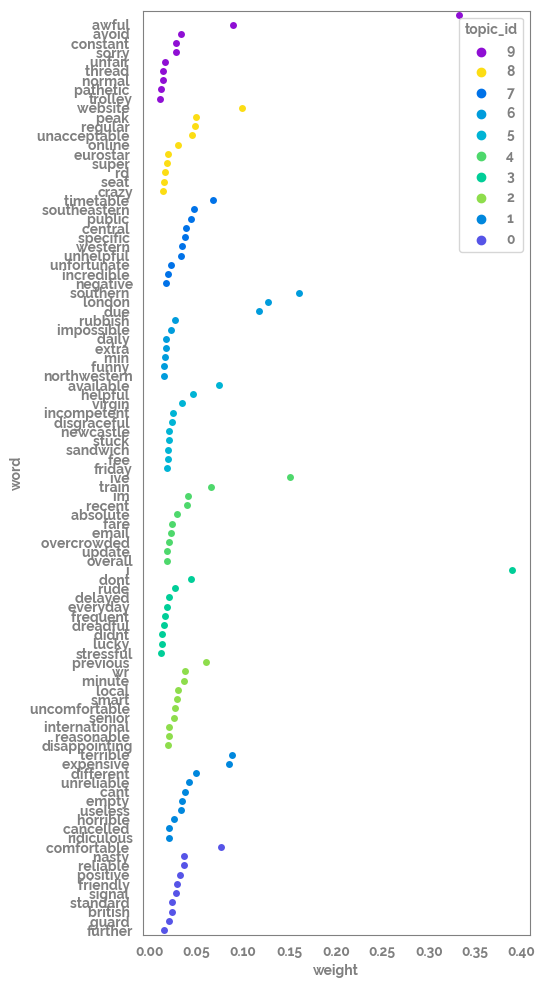

In [14]:
_ = plt.figure(figsize=(5, 12))
_ = sns.stripplot(
    data=topics_df.sort_values(by=["topic_id", "weight"], ascending=False),
    x="weight",
    y="word",
    hue="topic_id",
)

In [15]:
# ### Topic Extraction with LDA, NMF, and LSA (sklearn)

In [16]:
def sklearn_pipeline(
    list_of_texts, approach="LDA", n_components=10, n_top_words=10, beta_loss="frobenius", plot=True
):
    if approach == "LDA":
        tf_vectorizer = CountVectorizer()
        tf = tf_vectorizer.fit_transform(list_of_texts)
        lda = LatentDirichletAllocation(
            n_components=n_components,
            max_iter=5,
            learning_method="online",
            learning_offset=50.0,
            random_state=0,
        )
        _ = lda.fit(tf)
        
        feature_names = tf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            df_list.append(
                pd.DataFrame(
                    {"topic_id": topic_idx, "word": top_features, "weight": weights}
                )
            )
        
        return pd.concat(df_list).assign(**{"topic_id": lambda x: x["topic_id"].astype(str)})
    elif approach == "NMF":
        tfidf_vectorizer = TfidfVectorizer()
        tfidf = tfidf_vectorizer.fit_transform(list_of_texts)
        if beta_loss == "frobenius":
            nmf = NMF(
                n_components=n_components,
                random_state=0,
                beta_loss=beta_loss,
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=1,
                init="nndsvd",
            )
            _ = nmf.fit(tfidf)
        elif beta_loss == "kullback-leibler":
            nmf = NMF(
                n_components=n_components,
                random_state=0,
                init="nndsvd",
                beta_loss="kullback-leibler",
                solver="mu",
                max_iter=1000,
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=0.5,
            )
        else:
            raise ValueError("beta_loss must be either 'frobenius' or 'kullback-leibler'")
        
        _ = nmf.fit(tfidf)
        
        feature_names = tfidf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(nmf.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            df_list.append(
                pd.DataFrame(
                    {"topic_id": topic_idx, "word": top_features, "weight": weights}
                )
            )
        
        return pd.concat(df_list).assign(**{"topic_id": lambda x: x["topic_id"].astype(str)})
    elif approach == "LSA":
        tfidf_vectorizer = TfidfVectorizer()
        tfidf = tfidf_vectorizer.fit_transform(list_of_texts)
        svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
        _ = svd.fit(tfidf)
        
        feature_names = tfidf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(svd.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            df_list.append(
                pd.DataFrame(
                    {"topic_id": topic_idx, "word": top_features, "weight": weights}
                )
            )
        
        return pd.concat(df_list).assign(**{"topic_id": lambda x: x["topic_id"].astype(str)})
    else:
        raise ValueError("approach must be either 'LDA', 'NMF', or 'LSA'")

In [17]:
topics_df = sklearn_pipeline(
    list_of_texts=df["adjectives_text"].tolist(),
    approach="LSA",
    # beta_loss="kullback-leibler",
    n_components=10,
    plot=True,
)

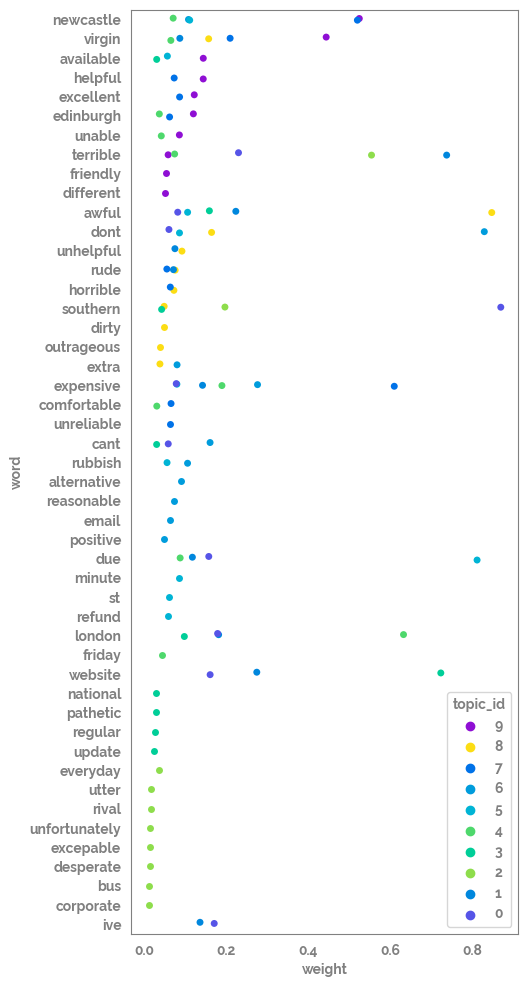

In [18]:
_ = plt.figure(figsize=(5, 12))
_ = sns.stripplot(
    data=topics_df.sort_values(by=["topic_id", "weight"], ascending=False),
    x="weight",
    y="word",
    hue="topic_id",
)